# Milestone 2
Grant Perkins

## Problem Statement
Can features be derived from the MBTA's reliability dataset to classify whether the Red Line Rapid Transit will be late during peak hours to at least 75% accuracy?

### Background
The Massachusetts Bay Transportation (MBTA) is the primary operator of public transportation in the greater Boston area. They provide consistent commuter rails, rapid transit, and buses for a minimal fee. The MBTA has a commitment to providing “accurate and timely information” about delays in their
services (https://www.mbta.com/policies/our-commitment-you). Predicting if the MBTA’s Red Line Rapid Transit will be late, based on the past month of data about the historical number of people trying to ride MBTA Rapid Transit and how many people got on the trains on time, would improve accuracy of reported information, in line with business goals. I will initially attempt using a Recurrent Neural Network (RNN) to solve this problem.

### Dataset Description
The dataset can be found here: [https://mbta-massdot.opendata.arcgis.com/datasets/MassDOT::mbta-bus-commuter-rail-rapid-transit-reliability/about](https://mbta-massdot.opendata.arcgis.com/datasets/MassDOT::mbta-bus-commuter-rail-rapid-transit-reliability/about)

The dataset I will use is the “MBTA Bus, Commuter Rail, & Rapid Transit Reliability”. This dataset is a daily report of reliability for all bus, commuter rails, and rapid transit options through the MBTA. It provides a timestamp, mode of transportation, number of people who used transport, and number of people who wanted to use transport. There are 8 million rows in this dataset, with timestamps ranging back from 2015 to the start of December in 2022. There is exactly one row for each day. It is not intraday data unfortunately, so there is no data about what specific times trains were late or canceled.

This dataset is easily accessible as a CSV file with over 8 million rows. The dataset is updated every few months, as the last update was November 30, 2022. I will only be using this data for this project. I will be removing a large chunk of this dataset, as I am only interested in Rapid Transit trains during peak hours.

# EDA Code


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import torch
from torch import nn

### Load Dataset
In this section, I am loading a preprocessing the dataset for training and prediction. The following steps are taken:
 - Load raw csv
 - Isolate rapid transit trains during peak hours
 - Reshape df from one row for each day, each line, to one row for each day with columns for each line
 - Interpolate missing values with medians per column (from EDA)
 - Save df for future use
 - Separate prediction variables from labels (red line reliability)
 - Use sliding window to create 30 day periods to predict
 - Split dataset 60:20:20 train:validation:test

In [ ]:
# load raw csv
df = pd.read_csv(r"C:\Users\gcper\OneDrive\WPI\ML\final\MBTA_Reliability.csv")

# isolate rapid transit trains during peak hours
df = df[(df["gtfs_route_desc"] == "Rapid Transit") & (df["mode_type"] == "Rail") & (df["peak_offpeak_ind"] == "PEAK")]
df["service_date"] = df["service_date"].apply(lambda s: s.split()[0])
routes = df["gtfs_route_id"].unique()

# reshape df
# make template df, one row for each date
new_df = pd.DataFrame({"service_date": df.service_date.unique()})
for route in routes:
    # make a column for each route's numerator and denominator
    route_df = df[df.gtfs_route_id == route][["service_date", "otp_numerator", "otp_denominator"]]
    route_df = route_df.rename({"otp_numerator": f"{route}_Numerator", "otp_denominator": f"{route}_Denominator"},
                               errors="raise", axis=1)
    new_df = new_df.merge(route_df, left_on="service_date", right_on="service_date",
                          how="left")  # puts NaNs where data is missing (how=left)
new_df.service_date = pd.to_datetime(new_df.service_date, format="%Y/%m/%d",
                                     errors="raise")  # convert service date to date type
new_df = new_df.sort_values(by="service_date", ascending=True)  # sort df by date, oldest to newest
new_df = new_df.rename({"service_date": "Date"}, axis=1)
new_df = new_df.set_index("Date")

# interpolate
for col in new_df.columns:
    new_df[col].fillna(value=new_df[col].median(), inplace=True)

# save final df
new_df.to_csv("mbta.csv")

In [4]:
def load_dataset(mbta_df, window=14, val_split=0.2, test_split=0.2, batch_size=8):
    # separate input and labels
    red_line = mbta_df["Red_Numerator"] / mbta_df["Red_Denominator"]
    variables_df = mbta_df[[col for col in mbta_df.columns if "Red" not in col and col != "Date"]]
    for col in variables_df.columns:
        series = variables_df[col]
        variables_df[col] = (series - series.min()) / (series.max()-series.min())
    
    # sliding window
    windows = variables_df.rolling(window=window)
    X = [window.to_numpy().astype(np.float64) for window in windows]
    X = X[window-1:-1] # first `window` windows are cut short, drop last window as well (can't predict)
#     X = [torch.tensor(i).float() for i in X] # convert to tensor
    X = torch.tensor(X).float().cpu()
    y = red_line.to_numpy()
    y = y[window:]
#     y = 1.0 * (y < 0.91) # define unreliable as < 90%
#     y = y[window:].astype(np.uint8) # offset labels. trying to predict the NEXT day
#     zeros = np.zeros((y.size, 2))
#     zeros[np.arange(y.size), y] = 1
#     y = zeros
    y = y.reshape((-1, 1))
    y = torch.tensor(y).float().cpu() # convert to tensor
    
    # train - validation - test split
    # 60 : 20 : 20
    length = len(y)
    train_length = int((1 - val_split - test_split) * length)
    val_length = int(val_split * length)
    test_length = int(test_split * length)
    print(f"{train_length} samples in train set")
    print(f"{val_length} samples in val set")
    print(f"{test_length} samples in test set")
    train_X, train_y = X[:train_length], y[:train_length]
    val_X, val_y = X[train_length:train_length+val_length], y[train_length:train_length+val_length]
    test_X, test_y = X[train_length+val_length:], y[train_length+val_length:]
    
    train_ds = torch.utils.data.TensorDataset(train_X, train_y)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    val_ds = torch.utils.data.TensorDataset(val_X, val_y)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_ds = torch.utils.data.TensorDataset(test_X, test_y)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader

In [5]:
df = pd.read_csv("mbta.csv")
train_loader, val_loader, test_loader = load_dataset(df, window=30)
# print([i.shape for i in [train_X, train_y, val_X, val_y, test_X, test_y]])

1062 samples in train set
354 samples in val set
354 samples in test set


/tmp/ipykernel_17570/2651402583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_df[col] = (series - series.min()) / (series.max()-series.min())


In [6]:
len(train_loader.dataset)
from torch import nn
from collections import Counter

In [7]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
#         return self.softmax(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cpu() for t in (h0, c0)]

In [65]:
class CNN(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1d1 = nn.Conv1d(30,64,kernel_size=3)
        self.relu = nn.ReLU(inplace=True)
        self.conv1d2 = nn.Conv1d(64,32,kernel_size=3)
        self.conv1d3 = nn.Conv1d(32,16,kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(96,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d1(x)
        x = self.relu(x)
        x = self.conv1d2(x)
        x = self.relu(x)
        x = self.conv1d3(x)
        x = self.relu(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [ ]:
input_dim = 12  
hidden_dim = 64
layer_dim = 5
output_dim = 1

lr = 0.0001
n_epochs = 1000
iterations_per_epoch = len(train_loader)
best_acc = 0
patience, trials = 100, 0

# model = CNN(30*input_dim)
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to("cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = [[], []]

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        x_batch = x_batch.cpu()
        y_batch = y_batch.cpu()
        optimizer.zero_grad()
        out = model(x_batch)
#         print(out)
        loss = criterion(out, y_batch)
        losses[0].append(loss)
        loss.backward()
        optimizer.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_loader:
        x_val, y_val = [t.cpu() for t in (x_val, y_val)]
        out = model(x_val)
        loss = criterion(out, y_val)
        losses[1].append(loss)
        
        y_val = y_val < 0.91
        preds = out < 0.91
        print(out.detach().numpy().ravel())
#         print(Counter(preds.numpy()))
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.7f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


Start model training
[0.94095    0.9405973  0.94088227 0.94038314 0.94103473 0.94177717
 0.9408472  0.94077295]
[0.94133645 0.9415708  0.9409116  0.941785   0.94231635 0.9412316
 0.9418817  0.9414716 ]
[0.9416234  0.9426399  0.9428611  0.9426738  0.94260174 0.94303364
 0.9431227  0.9415252 ]
[0.94070274 0.94130975 0.9405905  0.9414867  0.94012433 0.9410102
 0.9415299  0.9405739 ]
[0.9411523  0.9405032  0.9395185  0.9409837  0.939531   0.9402931
 0.94036555 0.9401569 ]
[0.9418413  0.9408276  0.9420915  0.9408911  0.94104725 0.94178563
 0.9412639  0.9421317 ]
[0.9428083  0.94233626 0.94241184 0.94113034 0.93964875 0.93593585
 0.93362373 0.9306378 ]
[0.9269045  0.92433614 0.9222347  0.9171317  0.91548735 0.91400653
 0.9142657  0.9122713 ]
[0.91354305 0.914072   0.9148284  0.91711104 0.917793   0.91985
 0.9218022  0.92247134]
[0.9238774  0.92404485 0.92734426 0.9272852  0.92885303 0.9279371
 0.93009615 0.9296791 ]
[0.92816097 0.9296062  0.9280693  0.9286689  0.9280111  0.9297516
 0.9285686

[0.9784292  0.9804509  0.9801735  0.9785698  0.9787447  0.98014575
 0.97857165 0.9791959 ]
[0.9792224  0.9790166  0.97910386 0.97972673 0.97816414 0.97941047
 0.9803437  0.9808879 ]
[0.98024565 0.98034006 0.9803782  0.9794695  0.97940415 0.97980475
 0.9797567  0.97918063]
[0.979627   0.97955054 0.9782304  0.97882706 0.97803926 0.9788476
 0.9783755  0.9784158 ]
[0.97741926 0.97790414 0.9775447  0.97863543 0.9789656  0.97822654
 0.9793251  0.9787831 ]
[0.97887427 0.9785808  0.97908545 0.9792779  0.9802769  0.98045
 0.9804402  0.9803987 ]
[0.9813112  0.97990113 0.97921586 0.9786865  0.9767881  0.97486013
 0.97334003 0.96965635]
[0.96612734 0.9629912  0.9606595  0.95840365 0.95610166 0.9546775
 0.95458835 0.9537021 ]
[0.9538411  0.9568346  0.9573217  0.9583679  0.9592664  0.9603103
 0.96246475 0.9629406 ]
[0.963126   0.96523035 0.9666893  0.9667228  0.9671104  0.9672614
 0.9673768  0.9677232 ]
[0.96696126 0.9669383  0.9666341  0.96694726 0.96847296 0.96801573
 0.9670947  0.96788865]
[0.966

[0.97539634 0.9752145  0.9749973  0.9754968  0.97607017 0.97524834
 0.97489774 0.9757721 ]
[0.9758845  0.9750531  0.97414    0.97562903 0.975685   0.97544134
 0.97571    0.97570956]
[0.97661084 0.97618574 0.97638583 0.9758198  0.9758898  0.9765848
 0.97630525 0.9757734 ]
[0.9752132  0.97513264 0.97461885 0.97445756 0.9752308  0.97482497
 0.97423714 0.9744622 ]
[0.9748873  0.9747034  0.97464395 0.9744868  0.97445047 0.97494185
 0.9748027  0.97536194]
[0.97584224 0.9759052  0.97576237 0.976177   0.9758965  0.97613007
 0.9767542  0.97632957]
[0.9762226  0.97628754 0.975152   0.9744757  0.9733167  0.9712575
 0.96935904 0.96619546]
[0.9643442  0.96195734 0.95903814 0.9564918  0.955879   0.9536388
 0.95429015 0.9541453 ]
[0.9544147  0.9548329  0.9553742  0.95719004 0.9586852  0.95897007
 0.9598414  0.9612463 ]
[0.9618758  0.9625473  0.9640308  0.9643642  0.96455944 0.96489435
 0.96524477 0.9645505 ]
[0.9647094  0.96521604 0.96400017 0.9652667  0.9647904  0.9652951
 0.965073   0.96466553]
[0.

[0.9662812  0.96691346 0.9660497  0.9665755  0.966619   0.966511
 0.9667438  0.96691173]
[0.96628296 0.9662767  0.96645725 0.9667885  0.966878   0.9664245
 0.9669928  0.9672866 ]
[0.9673545  0.96688795 0.966794   0.96716225 0.9672293  0.96684074
 0.9669377  0.9668676 ]
[0.9664226  0.96646714 0.9662968  0.9662167  0.96652937 0.96576583
 0.9661175  0.9663616 ]
[0.96573293 0.9660629  0.96626097 0.9660756  0.96598077 0.96605223
 0.96612144 0.96617746]
[0.9662014  0.9665757  0.9666767  0.9671026  0.9673127  0.96734643
 0.9672067  0.96751076]
[0.9672713  0.966503   0.9667774  0.9654827  0.96474814 0.9626897
 0.96075076 0.95876014]
[0.95659935 0.9544482  0.95235014 0.94994855 0.94907075 0.9480423
 0.94707173 0.9478978 ]
[0.9479358  0.94887096 0.94931114 0.9507792  0.9523109  0.95228744
 0.9529151  0.954395  ]
[0.9553106  0.9558677  0.9563608  0.9569774  0.95692647 0.9578443
 0.95748365 0.9566721 ]
[0.9568908  0.956358   0.9568387  0.9570853  0.9569092  0.95759296
 0.95757824 0.95685947]
[0.95

[0.95799154 0.9576978  0.95762354 0.9577188  0.95781773 0.9580427
 0.95713645 0.9576282 ]
[0.9578211  0.95747465 0.9574663  0.95738065 0.9577298  0.9578373
 0.9577065  0.9583999 ]
[0.95797235 0.9582638  0.9578729  0.9580756  0.95805717 0.958196
 0.95795226 0.9577151 ]
[0.95759803 0.9576698  0.95719403 0.9575222  0.9571157  0.9572132
 0.95681196 0.9566963 ]
[0.9567786  0.95689994 0.9575598  0.9572641  0.95690954 0.95721644
 0.9574848  0.9575702 ]
[0.95749605 0.95774406 0.95767033 0.9577101  0.95800024 0.95800513
 0.9583821  0.9581704 ]
[0.9586941  0.9581557  0.95757544 0.95682937 0.95589477 0.9543008
 0.9522704  0.9501751 ]
[0.94823134 0.946746   0.94439226 0.9425881  0.9414093  0.9404362
 0.9404802  0.9405912 ]
[0.941089  0.9420001 0.9423077 0.9433482 0.944702  0.9452894 0.9459771
 0.947084 ]
[0.9476782  0.9484168  0.94842905 0.94946826 0.94911045 0.94961506
 0.94881517 0.94902664]
[0.94911116 0.94858986 0.94864416 0.94866496 0.9489715  0.9487628
 0.9484246  0.94938123]
[0.9480303  0.9

[0.9536643  0.9534555  0.95333725 0.9533859  0.95319843 0.9534592
 0.9534822  0.9534477 ]
[0.9536532  0.9531825  0.9532942  0.95334953 0.95339745 0.9534004
 0.953816   0.95391077]
[0.95351154 0.9538168  0.9538736  0.95390254 0.9540125  0.9538689
 0.9536339  0.9534734 ]
[0.9535393  0.95283914 0.9530551  0.95292187 0.95306534 0.953003
 0.95276445 0.9532607 ]
[0.95277196 0.95278496 0.9528675  0.9528242  0.95310944 0.9532112
 0.9533662  0.9531912 ]
[0.9531649  0.9534965  0.9538041  0.95361    0.9535877  0.95395654
 0.9540002  0.9540565 ]
[0.9539006  0.95372504 0.9535304  0.95266813 0.95132977 0.95013255
 0.9486955  0.94679624]
[0.9451422  0.943294   0.94078135 0.93995667 0.9385938  0.93793726
 0.9375345  0.93757385]
[0.9385051  0.93863046 0.9398616  0.9404118  0.94175744 0.9419928
 0.94242173 0.9435566 ]
[0.94382197 0.9447465  0.94519013 0.94537157 0.9459776  0.9456204
 0.9453368  0.9456089 ]
[0.94496506 0.9448251  0.94489855 0.9445018  0.94521046 0.94526386
 0.9452625  0.9453627 ]
[0.9455

[0.93994606 0.9402268  0.9402878  0.940182   0.94037867 0.9404945
 0.9402436  0.94008744]
[0.9401902  0.940269   0.9402279  0.94007206 0.9403026  0.9401125
 0.9406886  0.94042844]
[0.94072765 0.9407034  0.9405454  0.940192   0.9403712  0.94059837
 0.9403407  0.9403225 ]
[0.94009465 0.939932   0.9396949  0.9402245  0.93980306 0.93973684
 0.9396418  0.9395216 ]
[0.9394755  0.93945205 0.9396423  0.93986154 0.9399418  0.93977046
 0.94004905 0.9400315 ]
[0.9403204  0.9399332  0.9403297  0.9401991  0.94033873 0.9404347
 0.9407947  0.9408637 ]
[0.9407828  0.9406278  0.9402627  0.93911356 0.93872607 0.93746966
 0.9362667  0.9343247 ]
[0.932932   0.93096507 0.929208   0.92756057 0.9268409  0.9261869
 0.92595553 0.92620254]
[0.92643857 0.9271002  0.9275384  0.9281916  0.9288972  0.9301215
 0.9299582  0.93117505]
[0.9316635  0.9320619  0.93222475 0.9328259  0.932732   0.9331118
 0.93319136 0.9326592 ]
[0.9322636  0.9321022  0.9322314  0.93226486 0.9323199  0.932482
 0.93273497 0.9323198 ]
[0.9324

[0.93265975 0.9324532  0.9323117  0.9324688  0.93247044 0.93218935
 0.9324348  0.93255615]
[0.9323214  0.9323093  0.93241644 0.9323553  0.9324843  0.93253976
 0.93272865 0.93281204]
[0.93250245 0.9324544  0.93307936 0.93256676 0.93255484 0.9327369
 0.93256235 0.93256223]
[0.93219566 0.93219864 0.9322474  0.93212086 0.9318326  0.9319316
 0.93221414 0.9320289 ]
[0.93193793 0.9320912  0.93210894 0.93209076 0.93188566 0.93231905
 0.9323196  0.9323821 ]
[0.93229663 0.93252504 0.93283165 0.9324857  0.9329438  0.9326745
 0.9330174  0.93293715]
[0.93276143 0.93274    0.93223095 0.93172765 0.9308857  0.92970186
 0.92856467 0.9271807 ]
[0.9257457  0.92442626 0.92236924 0.92101693 0.9198594  0.9196419
 0.91955215 0.91928995]
[0.9195819  0.92047614 0.92079246 0.9215098  0.92192453 0.9225463
 0.92353433 0.9235572 ]
[0.92466736 0.924708   0.92532706 0.9253664  0.9254912  0.92568797
 0.92542416 0.9254211 ]
[0.92523515 0.9247223  0.9251076  0.92493594 0.92522293 0.92511827
 0.9253699  0.9255585 ]
[0.9

[0.92693967 0.92677546 0.9268542  0.9270442  0.9268763  0.9269748
 0.92682225 0.92687273]
[0.9267302  0.9265022  0.926811   0.92689455 0.92699194 0.927063
 0.9270371  0.9270364 ]
[0.9269805  0.92712665 0.9272779  0.92706585 0.9271579  0.9272539
 0.927006   0.927051  ]
[0.92682636 0.9266276  0.9267441  0.92657626 0.9265442  0.92664963
 0.9265553  0.9264944 ]
[0.9264937  0.92637944 0.9267707  0.926464   0.92666626 0.92652863
 0.9267713  0.9267266 ]
[0.9269285  0.9268902  0.92684317 0.9270732  0.9271357  0.9272425
 0.9269748  0.92715776]
[0.92736375 0.92705524 0.92674845 0.9262851  0.9255283  0.9247582
 0.92365235 0.9224498 ]
[0.9210344  0.9195801  0.91819966 0.91728354 0.916064   0.9155859
 0.915363   0.91547734]
[0.91569114 0.9160509  0.916669   0.91731954 0.9177897  0.9182987
 0.9187626  0.9193859 ]
[0.9197197  0.9201634  0.92078465 0.92099404 0.92102146 0.92110425
 0.9207088  0.9204943 ]
[0.9206277  0.9202619  0.92044234 0.9204431  0.92029536 0.9207201
 0.9208718  0.92058957]
[0.92071

[0.9205029  0.92038864 0.9206019  0.9204255  0.9204147  0.9203394
 0.9202655  0.92027307]
[0.9202717  0.9201908  0.9203263  0.9203487  0.9203455  0.9205132
 0.9205092  0.92061335]
[0.9203113  0.9205668  0.92058057 0.9205703  0.92068535 0.9205227
 0.9205171  0.92045695]
[0.9202542  0.9202583  0.9202952  0.92014396 0.92012626 0.91994053
 0.91983706 0.9200562 ]
[0.9199114  0.92006457 0.9199675  0.9201185  0.9202143  0.920338
 0.9203004  0.9202583 ]
[0.92009586 0.92042536 0.9204791  0.9204053  0.9203916  0.9205763
 0.9206759  0.92062664]
[0.92072713 0.9205738  0.9203455  0.91986233 0.9192819  0.91849273
 0.91761285 0.9164006 ]
[0.9151882  0.9138947  0.9127248  0.91175044 0.9108308  0.9102983
 0.91002315 0.9102162 ]
[0.9102181  0.91053814 0.9114244  0.9118218  0.91183484 0.91240984
 0.9129932  0.913436  ]
[0.9139318  0.91431355 0.9146229  0.9147941  0.9147561  0.9148496
 0.914877   0.9148347 ]
[0.9147752  0.9146064  0.9146141  0.9146663  0.9146856  0.9147438
 0.91441745 0.914987  ]
[0.91487

In [75]:
for i in range(2):
    for j in range(len(losses[i])):
        losses[i][j] = float(losses[i][j])
#         print(float(losses[i][j]))

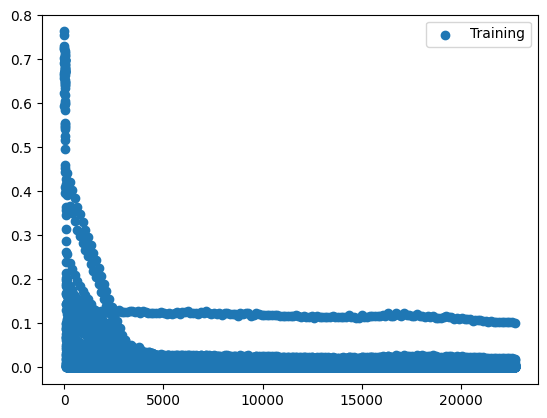

In [82]:
plt.scatter(range(len(losses[0])), losses[0], label="Training")
# plt.plot(range(len(losses[1])), losses[1], label="Validation")
plt.legend()
plt.show()

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.current_device()

In [ ]:
torch.cuda.get_device_name(0)

In [86]:
model.load_state_dict(torch.load("best.pth"))
model.eval()

CNN(
  (conv1d1): Conv1d(30, 64, kernel_size=(3,), stride=(1,))
  (relu): ReLU(inplace=True)
  (conv1d2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
  (conv1d3): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [88]:
for x_val, y_val in test_loader:
    x_val, y_val = [t.cpu() for t in (x_val, y_val)]
    out = model(x_val)
    loss = criterion(out, y_val)
    losses[1].append(loss)

    y_val = y_val < 0.91
    preds = out < 0.91
    #         print(preds)
    print(Counter(preds.numpy().ravel()))
    total += y_val.size(0)
    correct += (preds == y_val).sum().item()

acc = correct / total
acc

0.4708646616541353